In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# Training PINNs on the BIOQIC phantom dataset

The objective is to see if the best model identified so far on the FEM box data set can perform well on a more realistic and noisy dataset- the BIOQIC phantom dataset. I will use similar parameter ranges as the single-frequency 2D experiment, but I will try using helmholtz and heterogeneous PDEs as I'm not sure yet which will perform better on this data.

In [13]:
%autoreload
data, _ = mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', 'phantom')
data

Loading ../data/BIOQIC/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64
Loading ../data/BIOQIC/phantom_elastogram.npy
     <class 'numpy.ndarray'> (8, 128, 80, 25) complex128
Loading ../data/BIOQIC/phantom_regions.npy
     <class 'numpy.ndarray'> (128, 80, 25) int64
Preprocessing data
Multi frequency 3D
<xarray.Dataset>
Dimensions:         (frequency: 8, component: 3, z: 25, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component       (component) <U1 'z' 'y' 'x'
  * z               (z) float64 0.0 0.0015 0.003 0.0045 ... 0.033 0.0345 0.036
  * 

<xarray.Dataset>
Dimensions:         (frequency: 8, component: 3, z: 25, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component       (component) <U1 'z' 'y' 'x'
  * z               (z) float64 0.0 0.0015 0.003 0.0045 ... 0.033 0.0345 0.036
  * x               (x) float64 0.0 0.0015 0.003 0.0045 ... 0.1875 0.189 0.1905
  * y               (y) float64 0.0 0.0015 0.003 0.0045 ... 0.1155 0.117 0.1185
    spatial_region  (x, y, z) int64 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1
Data variables:
    a               (frequency, x, y, z, component) float64 0.0 0.0 ... 46.88
    u               (frequency, x, y, z, component) complex128 (-525.22761241...
    mu              (frequency, x, y, z) complex128 0j 0j 0j 0j ... 0j 0j 0j 0j
    Ku              (frequency, x, y, z, component) complex128 (24.8871884338...
    Lu              (frequency, x, y, z, component) complex128 (45161740.9209...
    Mu              (frequency, x, y, z) complex128 (112.7046953284758+76.953...

## Sweep 1 - model width and pde name

In [35]:
# define the job template and name format

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
source activate MRE-PINN

python ../../../train.py \\
    --data_root ../../../data/BIOQIC \\
    --data_name phantom \\
    --frequency {frequency} \\
    --xyz_slice {xyz_slice} \\
    --noise_ratio 0.0 \\
    --pde_name {pde_name} \\
    --omega0 {omega0} \\
    --n_layers {n_layers} \\
    --n_hidden {n_hidden} \\
    --activ_fn {activ_fn} \\
    --optimizer adam \\
    --learning_rate {learning_rate} \\
    --pde_loss_wt {pde_loss_wt} \\
    --data_loss_wt {data_loss_wt} \\
    --batch_size {batch_size} \\
    --n_iters {n_iters} \\
    --test_every {test_every} \\
    --save_every {save_every} \\
    --save_prefix {job_name}
'''
name = 'train_{frequency}_{xyz_slice}_{pde_name}_{omega0}_{n_hidden}_{activ_fn}'

# define the parameter space

param_space = ps.ParamSpace(
    frequency=[50, 60, 70, 80, 90, 100],
    xyz_slice=['2D'],
    pde_name=['helmholtz', 'hetero'],
    omega0=[16],
    n_layers=[5],
    n_hidden=[128, 256],
    activ_fn=['t'],
    learning_rate=1e-4,
    pde_loss_wt=1e-8,
    data_loss_wt=1,
    batch_size=128,
    n_iters=250000,
    test_every=1000,
    save_every=10000
)

len(param_space)

24

In [36]:
%autoreload
expt_name = '2022-09-23_phantom'

#jobs = ps.submit(template, name, param_space, work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

#import pandas as pd
#jobs = pd.read_csv(f'{expt_name}.jobs')

100%|██████████| 24/24 [00:02<00:00, 11.91it/s]
[11296099, 11296100, 11296101, 11296102, 11296103, 11296104, 11296105, 11296106, 11296107, 11296108, 11296109, 11296110, 11296111, 11296112, 11296113, 11296114, 11296115, 11296116, 11296117, 11296118, 11296119, 11296120, 11296121, 11296122]


In [44]:
%autoreload
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
ps.status(jobs)[status_cols] #.iloc[0].stderr

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
11296099,train_50_2D_helmholtz_16_128_t,NaN,NaN,NaN,v003.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
11296100,train_50_2D_helmholtz_16_256_t,NaN,NaN,NaN,v008.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
11296101,train_50_2D_hetero_16_128_t,NaN,NaN,NaN,v008.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
11296102,train_50_2D_hetero_16_256_t,NaN,NaN,NaN,v017.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
11296103,train_60_2D_helmholtz_16_128_t,NaN,NaN,NaN,v017.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
11296104,train_60_2D_helmholtz_16_256_t,NaN,NaN,NaN,v029.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
11296105,train_60_2D_hetero_16_128_t,NaN,NaN,NaN,v010.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
11296106,train_60_2D_hetero_16_256_t,NaN,NaN,NaN,v030.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
11296107,train_70_2D_helmholtz_16_128_t,NaN,NaN,NaN,v021.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n


In [47]:
print(ps.status(jobs)[status_cols].iloc[0].stdout)

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks/2022-09-23_phantom/train_50_2D_helmholtz_16_128_t
{'data_root': '../../../data/BIOQIC', 'data_name': 'phantom', 'frequency': 50, 'xyz_slice': '2D', 'noise_ratio': 0.0, 'pde_name': 'helmholtz', 'omega0': 16, 'n_layers': 5, 'n_hidden': 128, 'activ_fn': 't', 'optimizer': 'adam', 'learning_rate': 0.0001, 'pde_loss_wt': 1e-08, 'data_loss_wt': 1.0, 'batch_size': 128, 'n_iters': 250000, 'test_every': 1000, 'save_every': 10000, 'save_prefix': 'train_50_2D_helmholtz_16_128_t'}
Loading ../../../data/BIOQIC/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3

In [112]:
metrics = ps.metrics(jobs).rename(columns={'mean_abs_value': 'median_abs_value'})
metrics

,frequency,xyz_slice,pde_name,omega0,n_layers,n_hidden,activ_fn,learning_rate,pde_loss_wt,data_loss_wt,...,array_idx,iteration,variable_type,variable_source,variable_name,spatial_frequency_bin,spatial_region,mean_squared_abs_value,power_density,median_abs_value
0,50,2D,helmholtz,16,5,128,t,0.0001,1.000000e-08,1,...,NaN,0,wave field,model,u_pred,all,all,2.542053e+06,NaN,NaN
1,50,2D,helmholtz,16,5,128,t,0.0001,1.000000e-08,1,...,NaN,0,wave field,model,u_pred,1.0,all,NaN,9.101086e+07,NaN
2,50,2D,helmholtz,16,5,128,t,0.0001,1.000000e-08,1,...,NaN,0,wave field,model,u_pred,2.0,all,NaN,6.370607e+07,NaN
3,50,2D,helmholtz,16,5,128,t,0.0001,1.000000e-08,1,...,NaN,0,wave field,model,u_pred,3.0,all,NaN,6.469354e+06,NaN
4,50,2D,helmholtz,16,5,128,t,0.0001,1.000000e-08,1,...,NaN,0,wave field,model,u_pred,4.0,all,NaN,7.649691e+05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536115,100,2D,hetero,16,5,256,t,0.0001,1.000000e-08,1,...,NaN,250000,baseline,reference,mu_true,all,0,NaN,NaN,10148.713706
1536116,100,2D,hetero,16,5,256,t,0.0001,1.000000e-08,1,...,NaN,250000,baseline,reference,mu_true,all,1,NaN,NaN,35546.805453
1536117,100,2D,hetero,16,5,256,t,0.0001,1.000000e-08,1,...,NaN,250000,baseline,reference,mu_true,all,2,NaN,NaN,4930.725490
1536118,100,2D,hetero,16,5,256,t,0.0001,1.000000e-08,1,...,NaN,250000,baseline,reference,mu_true,all,3,NaN,NaN,5671.390928


In [114]:
# did all models train to 100k iterations?
assert (metrics.groupby('job_name')['iteration'].max() == 250e3).all()

param_cols = ['pde_name', 'frequency', 'n_hidden'] # experimental parameters
index_cols = ['iteration', 'variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['mean_squared_abs_value', 'power_density', 'median_abs_value'] # metric values

group_cols = ['job_name'] + param_cols + index_cols
m = metrics.groupby(group_cols, sort=False)[metric_cols].mean() \
    .unstack(level=[group_cols.index('variable_name')])

def abbreviate_metrics(t):
    metric_name, var_name = t
    metric_name = {
        'mean_squared_abs_value': 'MSAV',
        'median_abs_value': 'MAV',
        'power_density': 'PSD'
    }[metric_name]
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('f_sum_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

m.columns = [abbreviate_metrics(x) for x in m.columns.to_flat_index()]

m = m.reset_index()
m

,job_name,pde_name,frequency,n_hidden,iteration,spatial_frequency_bin,spatial_region,u_pred_MSAV,u_pred_MSAE,u_true_MSAV,...,lu_pred_MAD,Lu_pred_MAV,f_trac_MAV,f_sum_MAV,f_body_MAV,mu_pred_MAV,mu_pred_MAD,mu_true_MAV,Mu_MAV,Mu_pred_MAD
0,train_50_2D_helmholtz_16_128_t,helmholtz,50,128,0,all,all,2.542053e+06,3.428091e+06,808881.863744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,train_50_2D_helmholtz_16_128_t,helmholtz,50,128,0,all,-1,NaN,NaN,NaN,...,4330126.0,8239108.0,1.118663e+11,9.530538e+10,3.787887e+10,10168.360840,10168.360840,0.000000,263.968824,263.968824
2,train_50_2D_helmholtz_16_128_t,helmholtz,50,128,0,all,0,NaN,NaN,NaN,...,4428431.5,9413544.0,1.203487e+11,1.007722e+11,4.675818e+10,10031.539551,2075.120012,9990.971575,3857.742493,5599.965649
3,train_50_2D_helmholtz_16_128_t,helmholtz,50,128,0,all,1,NaN,NaN,NaN,...,5082423.5,17728484.0,1.984131e+11,1.267772e+11,1.437463e+11,11960.108398,21630.116315,34431.282331,458.144760,34576.984644
4,train_50_2D_helmholtz_16_128_t,helmholtz,50,128,0,all,2,NaN,NaN,NaN,...,4367089.0,15432016.0,2.468650e+11,1.823628e+11,6.608096e+10,12832.596680,5956.896232,4838.634399,3701.163577,1808.184673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102403,train_100_2D_hetero_16_256_t,hetero,100,256,250000,6.0,all,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102404,train_100_2D_hetero_16_256_t,hetero,100,256,250000,7.0,all,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102405,train_100_2D_hetero_16_256_t,hetero,100,256,250000,8.0,all,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102406,train_100_2D_hetero_16_256_t,hetero,100,256,250000,9.0,all,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
m.spatial_region.unique()

array(['all', '-1', '0', '1', '2', '3', '4'], dtype=object)

<IPython.core.display.Javascript object>


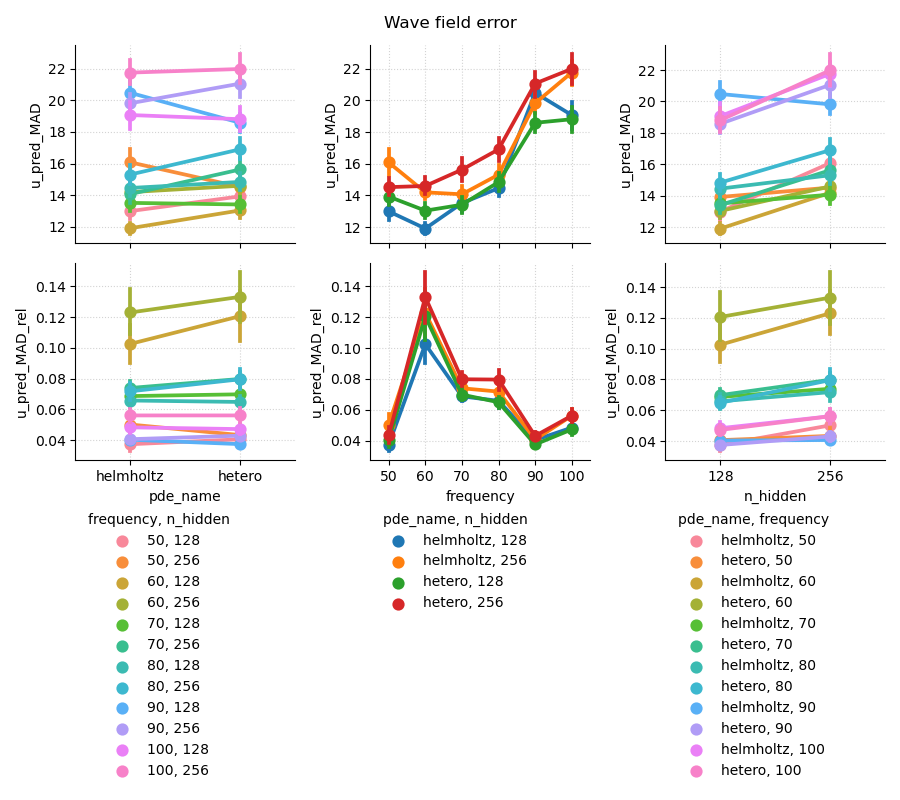

In [138]:
# plot the wave field error

m['u_pred_MSAE_rel'] = m['u_pred_MSAE'] / m['u_true_MSAV']
m['u_pred_MAD_rel'] = m['u_pred_MAD'] / m['u_true_MAV']

fig = ps.plot(
    m[(m.iteration > 200e3) & ~m.spatial_region.isin({'-1', 'all'})].copy(),
    x=param_cols,
    y=['u_pred_MAD', 'u_pred_MAD_rel'],
    grouped=True,
    height=4,
    width=3,
    legend=True,
    tight=True
)
fig.suptitle('Wave field error', x=0.5, y=0.98)
fig.tight_layout()

<IPython.core.display.Javascript object>


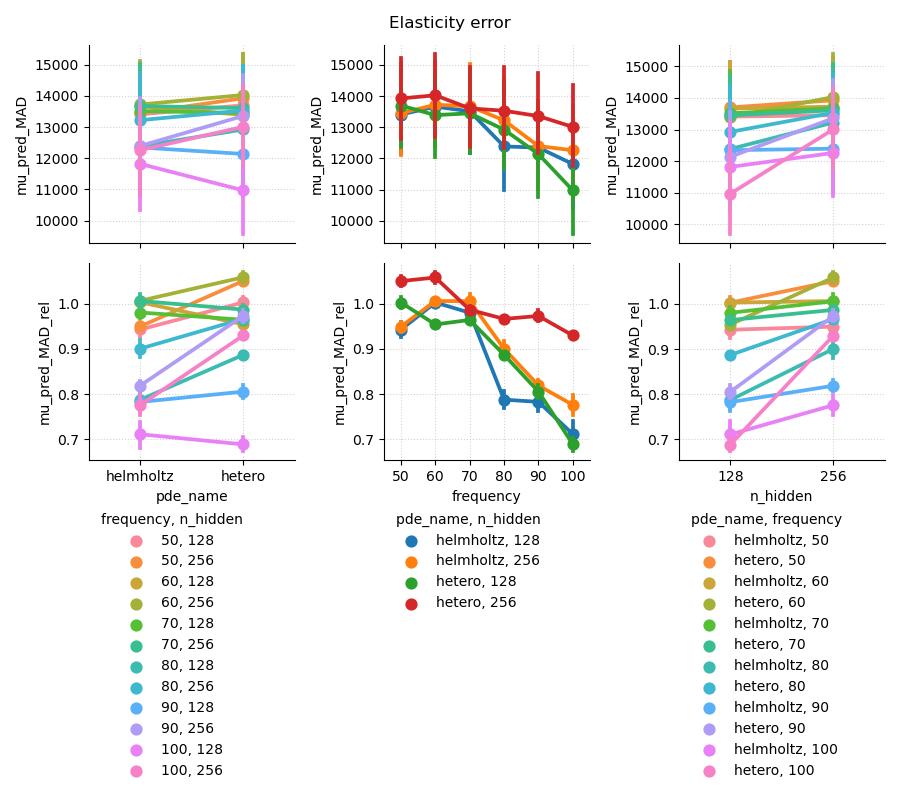

In [139]:
# plot the elastogram error

m['mu_pred_MSAE_rel'] = m['mu_pred_MSAE'] / m['mu_true_MSAV']
m['mu_pred_MAD_rel'] = m['mu_pred_MAD'] / m['mu_true_MAV']

fig = ps.plot(
    m[(m.iteration > 200e3) & ~m.spatial_region.isin({'-1', 'all'})].copy(),
    x=param_cols,
    y=['mu_pred_MAD', 'mu_pred_MAD_rel'],
    grouped=True,
    height=4,
    width=3,
    legend=True,
    tight=True
)
fig.suptitle('Elasticity error', x=0.5, y=0.98)
fig.tight_layout()

<IPython.core.display.Javascript object>


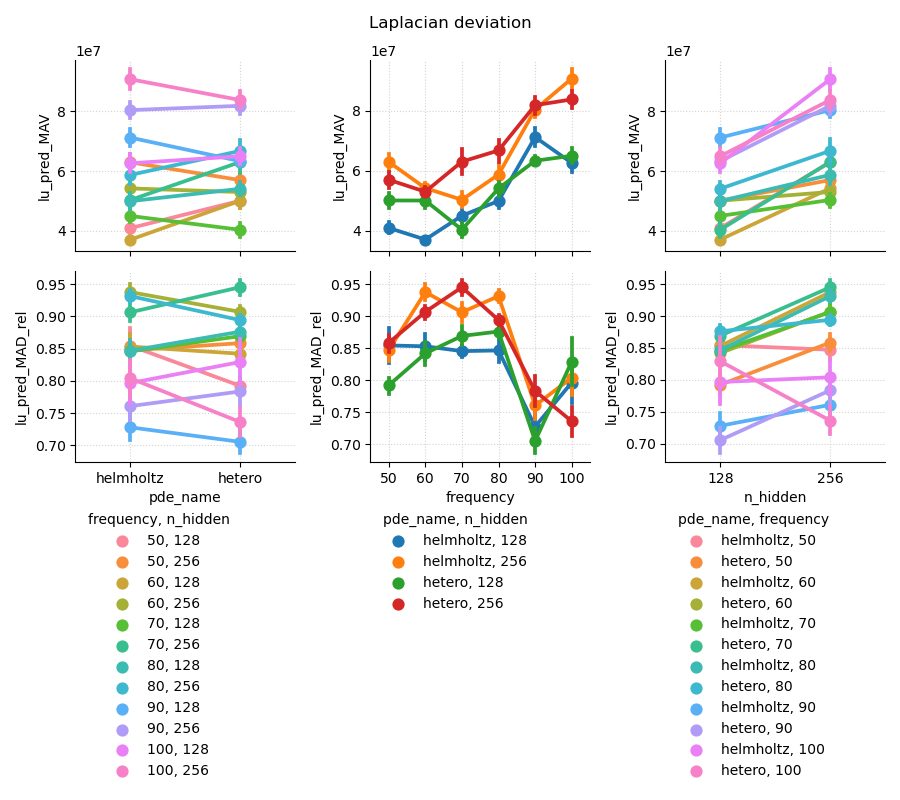

In [140]:
# plot the Laplacian error (model Laplacian vs finite differences) to assess overfitting

m['lu_pred_MSAE_rel'] = m['lu_pred_MSAE'] / m['lu_pred_MSAV']
m['lu_pred_MAD_rel'] = m['lu_pred_MAD'] / m['lu_pred_MAV']

fig = ps.plot(
    m[(m.iteration > 200e3) & ~m.spatial_region.isin({'-1', 'all'})].copy(),
    x=param_cols,
    y=['lu_pred_MAV', 'lu_pred_MAD_rel'],
    grouped=True,
    height=4,
    width=3,
    legend=True,
    tight=True
)
fig.suptitle('Laplacian deviation', x=0.5, y=0.98)
fig.tight_layout()